In [2]:
import importlib
import modules

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt


Transient length: no transient found


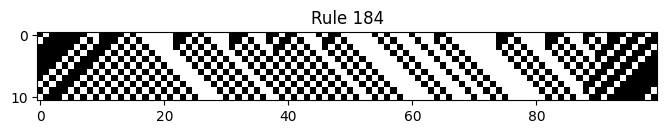

In [3]:
ca_184 = CA()

p = 0.5
L = 100
initial_state = ca_184.gen_initial_state_bernoulli(L, p)
lambda_parameter, evolution = ca_184.gen_CA(L, r=1, k=2, dec_rule=184, t_end=10, s_q='0')
transient_length = ca_184.calculate_transient_length()

plt.figure(figsize=(8,10))
plt.title(f'Rule 184')
plt.imshow(evolution, cmap='binary')

print(f"Transient length: {transient_length}")


In [4]:
import cellpylib as cpl
import numpy as np

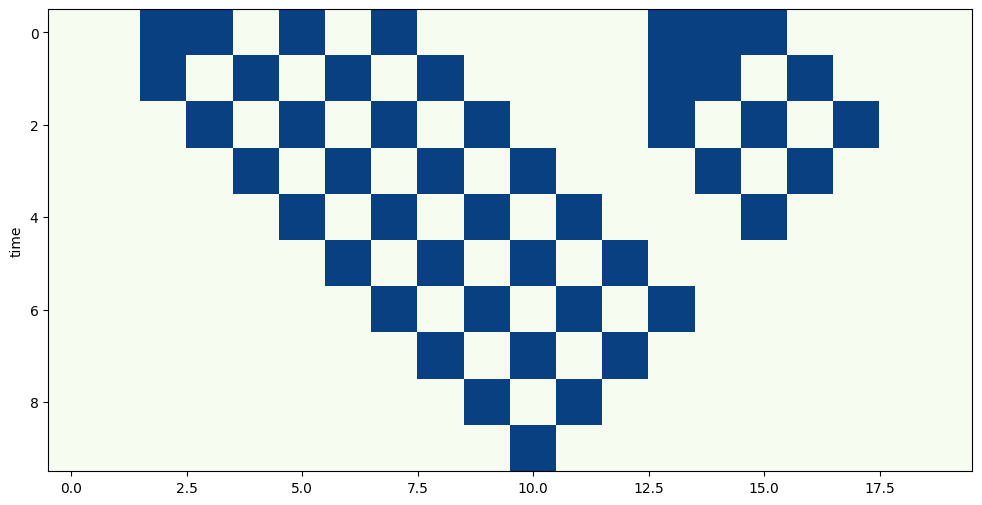

In [5]:
importlib.reload(modules)
from modules import triangulize_evolution

p = 0.5
L = 20
T = int(L / 2)
initial_state = ca_184.gen_initial_state_bernoulli(L, p)

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')



In [6]:
importlib.reload(modules)
from modules import find_elem_jams

jams = find_elem_jams(cellular_automaton)
print(f"The jams in the evolution above are: {jams}")
print(f"\'[[i, j], size]\' with i and j being the row coordinates in the row that the jam was last found in and size being the size of the jam.")
jam_sizes = [jam[1] for jam in jams]
print(f"Jam sizes: {jam_sizes}")

The jams in the evolution above are: [[[2, 3], 2], [[13, 14], 5]]
'[[i, j], size]' with i and j being the row coordinates in the row that the jam was last found in and size being the size of the jam.
Jam sizes: [2, 5]


[1, 2, 1, 2, 3, 4, 5, 6, 5, 4]


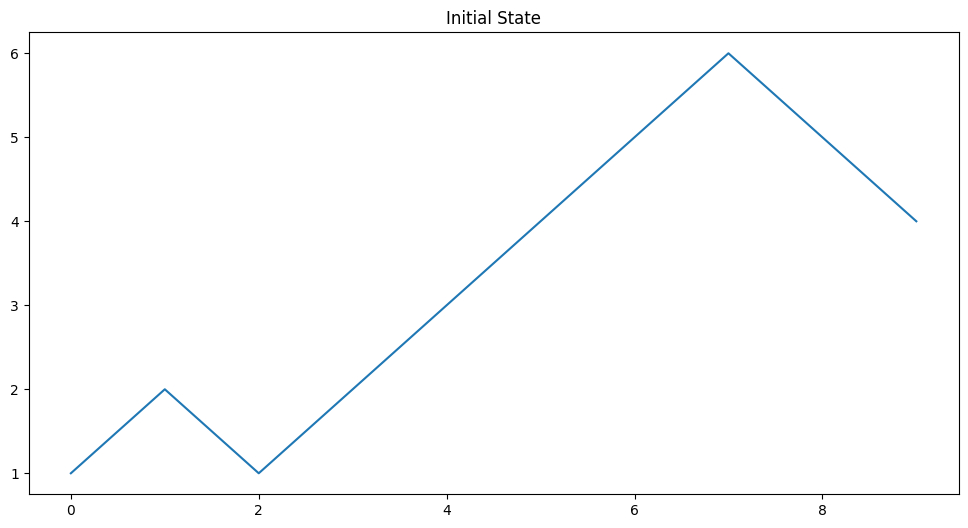

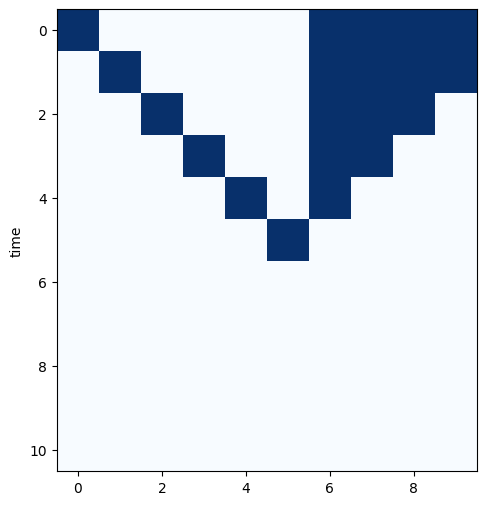

In [18]:
importlib.reload(modules)
from modules import triangulize_evolution
from modules import initial_to_random_walk

# Plot the random walk that is the initial state, go up for 1, down for 0
initial_state = np.array([[1, 1, 0, 1, 1, 1, 1, 1, 0, 0]])
random_walk = initial_to_random_walk(initial_state)
print(random_walk)
plt.figure(figsize=(12,6))
plt.title(f'Initial State')
plt.plot(random_walk)

_, cellular_automaton = ca_184.gen_CA(L, r=1, k=2, dec_rule=184, t_end=10, s_q='0')
# cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='Blues')





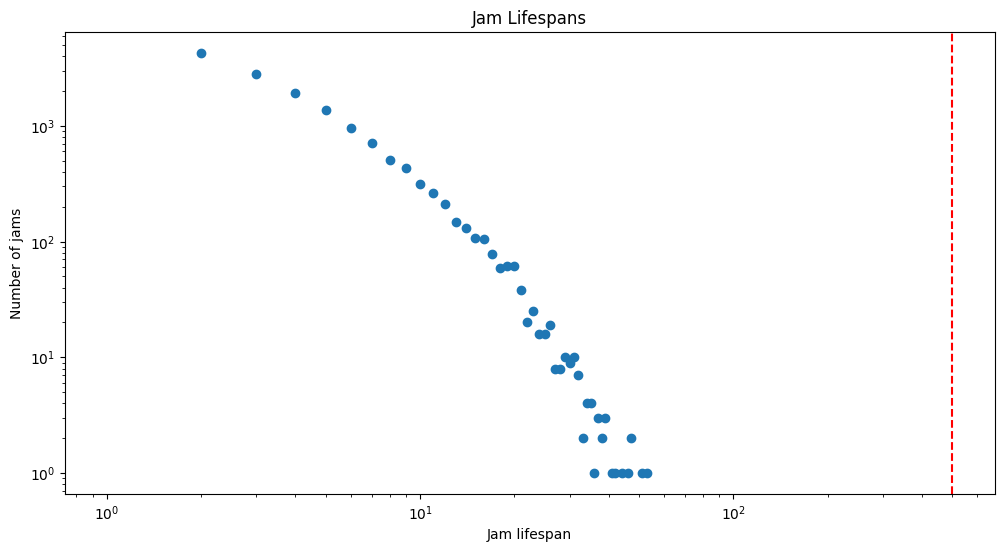

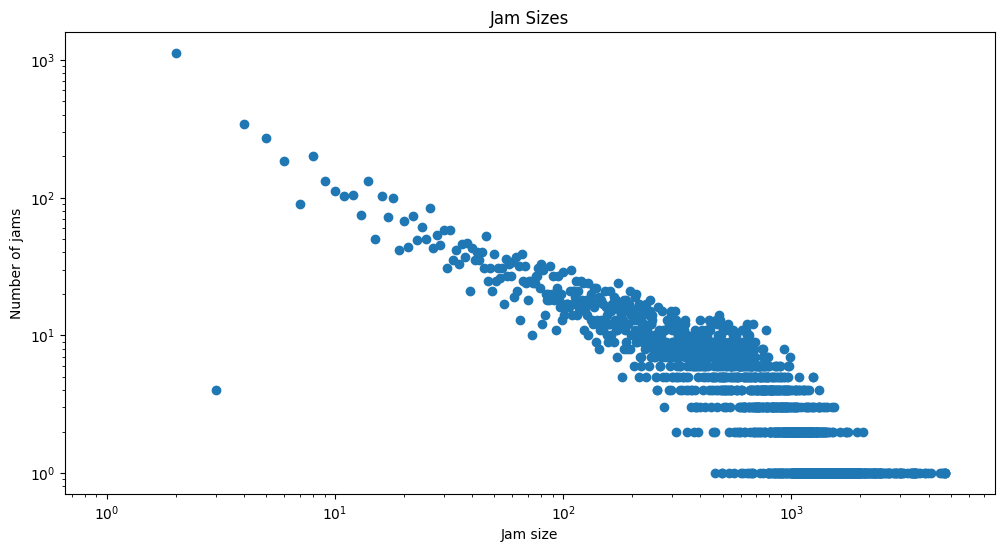

[(2, 1120), (3, 4), (4, 340), (5, 271), (6, 185), (7, 90), (8, 202), (9, 133), (10, 111), (11, 103), (12, 105), (13, 75), (14, 133), (15, 50), (16, 102), (17, 72), (18, 100), (19, 42), (20, 68), (21, 44), (22, 73), (23, 49), (24, 61), (25, 50), (26, 84), (27, 43), (28, 54), (29, 45), (30, 58), (31, 31), (32, 58), (33, 35), (34, 42), (35, 33), (36, 46), (37, 37), (38, 47), (39, 21), (40, 43), (41, 35), (42, 40), (43, 35), (44, 40), (45, 31), (46, 53), (47, 25), (48, 31), (49, 21), (50, 39), (51, 25), (52, 31), (53, 26), (54, 31), (55, 17), (56, 36), (57, 27), (58, 33), (59, 27), (60, 34), (61, 19), (62, 37), (63, 21), (64, 32), (65, 13), (66, 39), (67, 25), (68, 32), (69, 24), (70, 18), (71, 25), (72, 25), (73, 10), (74, 24), (75, 24), (76, 27), (77, 27), (78, 31), (79, 22), (80, 33), (81, 12), (82, 30), (83, 14), (84, 20), (85, 18), (86, 20), (87, 18), (88, 32), (89, 20), (90, 27), (91, 18), (92, 20), (93, 11), (94, 22), (95, 27), (96, 18), (97, 16), (98, 20), (99, 13), (100, 29), (101

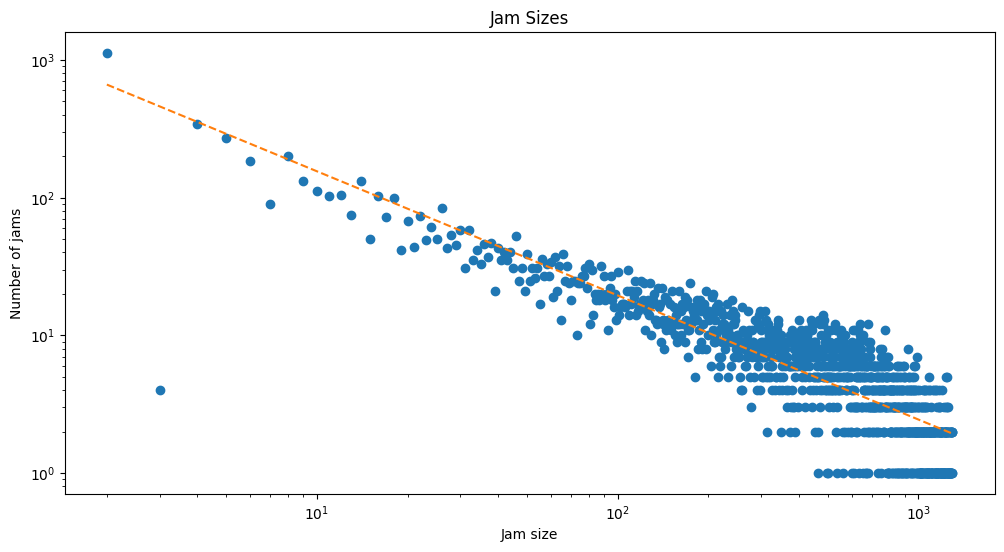

In [8]:
import scipy.optimize as opt
importlib.reload(modules)
from modules import run_model
from modules import run_model_stochastic

p = 0.5
L = 1000
T = int(L / 2)
n = 100

lifespan_counter, jam_size_counter = run_model_stochastic(p, L, T, n)

plt.figure(figsize=(12,6))
plt.title(f'Jam Lifespans')
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o')
plt.xlabel('Jam lifespan')
plt.ylabel('Number of jams')

# Add a vertical line at T
plt.axvline(x=T, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(12,6))
plt.title(f'Jam Sizes')
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o')
plt.xlabel('Jam size')
plt.ylabel('Number of jams')
plt.show()

# Try various fitting methods
def power_law_cutoff_func(x, a, b):
    return x** -a * np.exp(-b * x) 

jam_size_counter = sorted(jam_size_counter.items())

print(jam_size_counter)

x = np.array([i[0] for i in jam_size_counter])
y = np.array([i[1] for i in jam_size_counter])

def linear_func(x, a, b):
    return a * x + b

log_x, log_y = np.log(x), np.log(y)

# Take only 80% of the data to fit the line
x = x[:int(len(x) * 0.8)]
y = y[:int(len(y) * 0.8)]
log_x = log_x[:int(len(log_x) * 0.8)]
log_y = log_y[:int(len(log_y) * 0.8)]

# Fit a line to the log-log plot
popt, pcov = opt.curve_fit(linear_func, log_x, log_y)

# Plot the log-log plot
plt.figure(figsize=(12,6))
plt.title(f'Jam Sizes')
plt.loglog(x, y, 'o')
plt.loglog(x, np.exp(linear_func(log_x, *popt)), '--')
plt.xlabel('Jam size')
plt.ylabel('Number of jams')
plt.show()



Running model for p = 0.4


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Results for p = 0.4: [1.52673237179261, 1.3176834549868999, 1.3073523061240357, 1.3591467569728801, 1.4358585785559723, 1.3120017991132964, 1.4444921498736198, 1.5979361652304584, 1.538599891925954, 1.4833394142719512]
Running model for p = 0.40408163265306124


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Results for p = 0.40408163265306124: [1.3586632015687297, 1.3660284510372087, 1.3280340346575317, 1.552761261778029, 1.6178223082868841, 1.4017456808223827, 1.3471621748612816, 1.4315044953517155, 1.3289881677863442, 1.3278799739971228]
Running model for p = 0.40816326530612246


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Results for p = 0.40816326530612246: [1.3766715196194639, 1.5168759787428214, 1.4890256506905626, 1.355451554138941, 1.361113150523854, 1.3921989106988388, 1.2608400997593667, 1.3241684292937024, 1.3812563839256762, 1.2743777553891655]
Running model for p = 0.4122448979591837


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Results for p = 0.4122448979591837: [1.3643993963587786, 1.5542906814951725, 1.5447011500033003, 1.4783335872724424, 1.418396562017829, 1.3668493353764997, 1.3513984833202426, 1.4907309264741297, 1.336965451653531, 1.5393335989895003]
Running model for p = 0.4163265306122449


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Results for p = 0.4163265306122449: [1.3298242961900466, 1.334305993362924, 1.326390389289671, 1.5561871489397916, 1.3282334404133815, 1.4722658698211364, 1.3813709287050182, 1.3114627016950773, 1.307787765722207, 1.2464476815501102]
Running model for p = 0.42040816326530617


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Results for p = 0.42040816326530617: [1.2157490147545476, 1.4635072528252504, 1.383022030959752, 1.3635413608913014, 1.1897237758285766, 1.2209865094620718, 1.3112660711274184, 1.2591797104020492, 1.2372667220779865, 1.2985063651099475]
Running model for p = 0.4244897959183674


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Results for p = 0.4244897959183674: [1.2024905490062363, 1.279357809104787, 1.4024837525631217, 1.3272095903328676, 1.409571984589482, 1.195146059374981, 1.3338985693779055, 1.465541075801339, 1.1876323084313158, 1.3193118245069744]
Running model for p = 0.4285714285714286


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Results for p = 0.4285714285714286: [1.1394172940914653, 1.2163869877127231, 1.2329346309638063, 1.2135463768677555, 1.2733956000268514, 1.3015809916570185, 1.243715787873428, 1.3410047360687045, 1.355717597816605, 1.195146931039544]
Running model for p = 0.4326530612244898


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Results for p = 0.4326530612244898: [1.4347247003442658, 1.1970281398894764, 1.287457182132126, 1.1947317046985177, 1.2223389415846142, 1.2732861552503707, 1.2119208450207164, 1.3438618082786378, 1.2109515310684378, 1.1428113793840797]
Running model for p = 0.43673469387755104


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Results for p = 0.43673469387755104: [1.1817726563961655, 1.150076810903722, 1.250804150449841, 1.1772011530345967, 1.2023768120808191, 1.2239154909015797, 1.1247311491780758, 1.09927773946816, 1.3070797541280688, 1.2039895509695135]
Running model for p = 0.44081632653061226


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Results for p = 0.44081632653061226: [1.1902303479825553, 1.2181083986562036, 1.1666657643180758, 1.28242919726292, 1.1840873366397429, 1.184303342645626, 1.13058952345718, 1.1581953745911107, 1.1333121230081538, 1.042248752648601]
Running model for p = 0.4448979591836735


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Results for p = 0.4448979591836735: [1.182109181473464, 1.0023839264695809, 1.1420970239866683, 1.202455285448279, 1.1473553224324764, 1.0910585808500086, 1.0842773689084737, 1.085055102563741, 1.0979286927474943, 1.213509177116485]
Running model for p = 0.4489795918367347


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Results for p = 0.4489795918367347: [1.072881875699604, 1.233712110903964, 1.070597405101911, 1.0902973817201982, 1.046148997277398, 1.040575656660597, 1.0567733274305453, 1.1172375185813876, 1.06864735105074, 1.0253960596830134]
Running model for p = 0.4530612244897959


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.4530612244897959: [1.0797919437346482, 1.2242403638868353, 1.0200276428633985, 1.2293532858916363, 1.0833305408465408, 1.017578358887061, 1.1914488040611566, 1.051076826529326, 1.0456793056294118, 0.9621426103139619]
Running model for p = 0.4571428571428572


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Results for p = 0.4571428571428572: [1.0440427555097571, 0.975566371895626, 1.105729070622607, 1.1404383137803658, 1.008929013167007, 1.0619458883551685, 1.0897678564385815, 1.0257425930609583, 1.070768494755315, 1.0246736856002454]
Running model for p = 0.4612244897959184


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.4612244897959184: [0.9219192656673109, 1.094666018623118, 0.9901970940699651, 0.8719550111488608, 0.8746223688764697, 0.9598977381274095, 0.8843675798299693, 0.9888535349226042, 1.1434449907228366, 1.0213874664070772]
Running model for p = 0.4653061224489796


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Results for p = 0.4653061224489796: [0.9393078707351494, 0.9185871302607125, 0.9846253007832529, 0.965692299282268, 0.974189166331792, 0.9294427179657812, 0.9458449837204884, 0.9290489021314526, 0.979525112359021, 1.1273831777348353]
Running model for p = 0.46938775510204084


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.46938775510204084: [0.9110958606172919, 0.7209510798305706, 0.874256267338742, 0.8715470933438164, 0.991671611725763, 1.0380745942037704, 0.922804956249065, 0.9428002939862926, 0.8466144857554054, 0.9738670350921911]
Running model for p = 0.47346938775510206


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.47346938775510206: [0.9911269304145902, 0.9500694614184538, 0.9200086526973489, 0.8593068398841827, 0.9142848684107135, 0.8649251467996543, 0.8565110809245836, 0.827695724646736, 0.944016914382532, 0.8424308988809486]
Running model for p = 0.4775510204081633


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.4775510204081633: [0.8096495578274773, 0.841158805071154, 0.8603345133411379, 0.843219047381384, 0.8764812308344206, 0.6919407726336918, 0.7800940983031854, 0.8075876467893524, 0.9007887372580557, 0.7344987614424421]
Running model for p = 0.4816326530612245


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Results for p = 0.4816326530612245: [0.7615110592104635, 0.7465349851402301, 0.7136045475621827, 0.7143969245582025, 0.740385257004106, 0.8447209588513441, 0.8873033547333644, 0.860303379945847, 0.7603892825597897, 0.9061295554542359]
Running model for p = 0.4857142857142857


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Results for p = 0.4857142857142857: [0.8146030772755428, 0.7577039613554468, 0.8290775849681467, 0.7055553597771087, 0.659231568468243, 0.7100378864396731, 0.6689284613909907, 0.6731240415722631, 0.7762509968600714, 0.723530465725448]
Running model for p = 0.4897959183673469


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Results for p = 0.4897959183673469: [0.6694896660890668, 0.6739940213301359, 0.6393151861991994, 0.7345898517373431, 0.6624661205944129, 0.6581295625848336, 0.7386763597213306, 0.7813919882031359, 0.7419564695652976, 0.686504797360348]
Running model for p = 0.4938775510204082


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Results for p = 0.4938775510204082: [0.6693917394885951, 0.6296483562346693, 0.6348199434677162, 0.6125826495513155, 0.7070643383257882, 0.6501770578697104, 0.7349382301843915, 0.679158672655199, 0.7092472150219643, 0.5949170767609369]
Running model for p = 0.49795918367346936


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Results for p = 0.49795918367346936: [0.6709809380560456, 0.6014476315672241, 0.6546466039496107, 0.5818869490615656, 0.6663693935682412, 0.7016383053921227, 0.5534846813939279, 0.5306383076660693, 0.6034926826526806, 0.636095188005779]
Running model for p = 0.5020408163265306


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Results for p = 0.5020408163265306: [0.5354942412224839, 0.5453791002668216, 0.5208564825978883, 0.5553365136905202, 0.5214238034730072, 0.5937452975592732, 0.6569675564302876, 0.5936875965935576, 0.5080933094233302, 0.6301255868359491]
Running model for p = 0.5061224489795918


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Results for p = 0.5061224489795918: [0.43525835230678056, 0.48775194378792364, 0.5423209540738746, 0.5480462346270643, 0.5212303323191955, 0.4855193828010608, 0.5572147437949844, 0.4503379912275173, 0.57715616370101, 0.485050138039666]
Running model for p = 0.5102040816326531


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Results for p = 0.5102040816326531: [0.5156121883600869, 0.4642652454146971, 0.452809270089236, 0.4923008821385134, 0.4956497829011679, 0.3943847746088399, 0.37182786837013887, 0.5025754239044808, 0.5720239338288797, 0.4104837202968782]
Running model for p = 0.5142857142857142


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Results for p = 0.5142857142857142: [0.4241502086643985, 0.4687239099787497, 0.5296466085850503, 0.41287504322553653, 0.49223436868536935, 0.43095145759000486, 0.4255560511457195, 0.5317657772709138, 0.44186111597416033, 0.39815052873160117]
Running model for p = 0.5183673469387755


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Results for p = 0.5183673469387755: [0.457144396537284, 0.40674899032306927, 0.42658546992050017, 0.4311382147502727, 0.3538094450312209, 0.35474955632309574, 0.4970085620450828, 0.4814035874491569, 0.3910435246790549, 0.44637459222700215]
Running model for p = 0.5224489795918368


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Results for p = 0.5224489795918368: [0.40734210620584943, 0.38368488151914304, 0.38916251759725184, 0.3016449043082536, 0.38870107633782824, 0.35476297338080165, 0.3562884199767853, 0.4198931787418411, 0.3970115062057641, 0.40016897992477707]
Running model for p = 0.5265306122448979


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Results for p = 0.5265306122448979: [0.35386204464758697, 0.3741353992585542, 0.3980736443094159, 0.35240576120747025, 0.2865753764662753, 0.3277506560115998, 0.3491622145978571, 0.4087157288696269, 0.337338670376943, 0.3210512026657773]
Running model for p = 0.5306122448979592


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Results for p = 0.5306122448979592: [0.3827790764749359, 0.34467657430107335, 0.32359066883071586, 0.3254182361487466, 0.31400933298174766, 0.34722891088713803, 0.3276140864951044, 0.2718065746792203, 0.34253010369831594, 0.3122284500239423]
Running model for p = 0.5346938775510204


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Results for p = 0.5346938775510204: [0.3018540875686345, 0.2998628111721974, 0.3072126109617536, 0.2874373658762649, 0.2615911396715379, 0.31455007470661034, 0.3158069558885599, 0.2559082759443401, 0.3158077098753296, 0.2960006432836254]
Running model for p = 0.5387755102040817


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Results for p = 0.5387755102040817: [0.2876364079361371, 0.29478487744542403, 0.2823771884087991, 0.2491024860394901, 0.21641545922095662, 0.26492243749116673, 0.2154851959758266, 0.2654403598884354, 0.29390129034117496, 0.275819941718181]
Running model for p = 0.5428571428571429


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Results for p = 0.5428571428571429: [0.2522646540283423, 0.23860047293962872, 0.24874261639798337, 0.282048767458393, 0.2730555717100075, 0.2841672889424949, 0.24519870565955865, 0.23904315203912718, 0.2893344583744258, 0.23735806538437432]
Running model for p = 0.5469387755102041


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Results for p = 0.5469387755102041: [0.19974118324711196, 0.20004903350601821, 0.2615948364332811, 0.2265767306629236, 0.22826969066032304, 0.2095621969192517, 0.18139513006165658, 0.22907512384580095, 0.18585344469174192, 0.2712919346148699]
Running model for p = 0.5510204081632653


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Results for p = 0.5510204081632653: [0.22255339791705464, 0.2099384356499151, 0.22805240225409532, 0.21518758609749739, 0.25735920317872735, 0.2302695243466089, 0.19078873851469658, 0.26843620391447764, 0.26765718908146285, 0.23449313383698012]
Running model for p = 0.5551020408163265


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Results for p = 0.5551020408163265: [0.19253022334752035, 0.1844558188372314, 0.21897844777447095, 0.22241050360061787, 0.17822493008993767, 0.15701035100099248, 0.22556211183856945, 0.1987279029745642, 0.26519735185747884, 0.2263700955065824]
Running model for p = 0.5591836734693878


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Results for p = 0.5591836734693878: [0.1774500697897225, 0.17416989194257637, 0.21602926759032542, 0.1794341426652769, 0.2062738408913134, 0.19442537364921686, 0.18529003074851524, 0.17992037282482198, 0.20262924367026275, 0.18571483029737254]
Running model for p = 0.563265306122449


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Results for p = 0.563265306122449: [0.1902329538083612, 0.19797981307935975, 0.19278689597694465, 0.17758937313249512, 0.17887459162270747, 0.1814386855718304, 0.17907374299172885, 0.24566629739305185, 0.18793358595457166, 0.1944245210493175]
Running model for p = 0.5673469387755102


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Results for p = 0.5673469387755102: [0.20382781774077136, 0.16413071401763604, 0.16126316772025773, 0.16638518867922258, 0.1480050185303996, 0.14908838596029086, 0.1889091527182083, 0.17581630306963103, 0.16107209042177895, 0.1963115120256803]
Running model for p = 0.5714285714285714


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Results for p = 0.5714285714285714: [0.1711217107027384, 0.16912684065689043, 0.1731838384040495, 0.17165613358711562, 0.18252838428946028, 0.17414550482033964, 0.21689964851100388, 0.17532589043981994, 0.18671081284451296, 0.1793392653994762]
Running model for p = 0.5755102040816327


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Results for p = 0.5755102040816327: [0.1317438208801681, 0.19012346447584294, 0.1718653120015362, 0.14466995634202573, 0.15511234392212336, 0.14290558793204378, 0.21181711205939355, 0.1431671624864167, 0.20141261747873154, 0.19287186697903436]
Running model for p = 0.5795918367346939


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Results for p = 0.5795918367346939: [0.1733644762742126, 0.13316388712983507, 0.1718018456368937, 0.15434210400056259, 0.19603988754437485, 0.1478607402852975, 0.18183619031505552, 0.18928105782191829, 0.1751941616431481, 0.16004494565465077]
Running model for p = 0.5836734693877551


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Results for p = 0.5836734693877551: [0.13950977089465325, 0.16424347196853661, 0.1961774803210572, 0.18231192851788616, 0.16166021544069942, 0.11438500952326597, 0.16185305796189697, 0.17827107153084318, 0.16770579320421608, 0.12665517118212033]
Running model for p = 0.5877551020408163


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Results for p = 0.5877551020408163: [0.12571148989962588, 0.14935399528668483, 0.1696302414624909, 0.14579471993742485, 0.14147019419954557, 0.14496910030958915, 0.14903475657668652, 0.1508252891887737, 0.17867979257050243, 0.14381364250301665]
Running model for p = 0.5918367346938775


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Results for p = 0.5918367346938775: [0.17361042534548904, 0.16039288401870633, 0.13631175259111938, 0.16230611310476262, 0.1508023001684276, 0.14562562509590832, 0.14884107947356184, 0.17551448873338882, 0.16370185390385256, 0.14190469476961373]
Running model for p = 0.5959183673469388


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Results for p = 0.5959183673469388: [0.13823856827601266, 0.16054141224782895, 0.18688305875358188, 0.10191912338695103, 0.14820355994472167, 0.13144873072238095, 0.15766154909724628, 0.1505816471885656, 0.16868201735343227, 0.15301421724222708]
Running model for p = 0.6


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Results for p = 0.6: [0.18331827533092848, 0.1524534228223099, 0.15459950619051466, 0.13837673825571928, 0.17421726240185076, 0.1271992878288708, 0.14005576720338886, 0.16432975626989008, 0.1584611979040037, 0.12419641672178494]


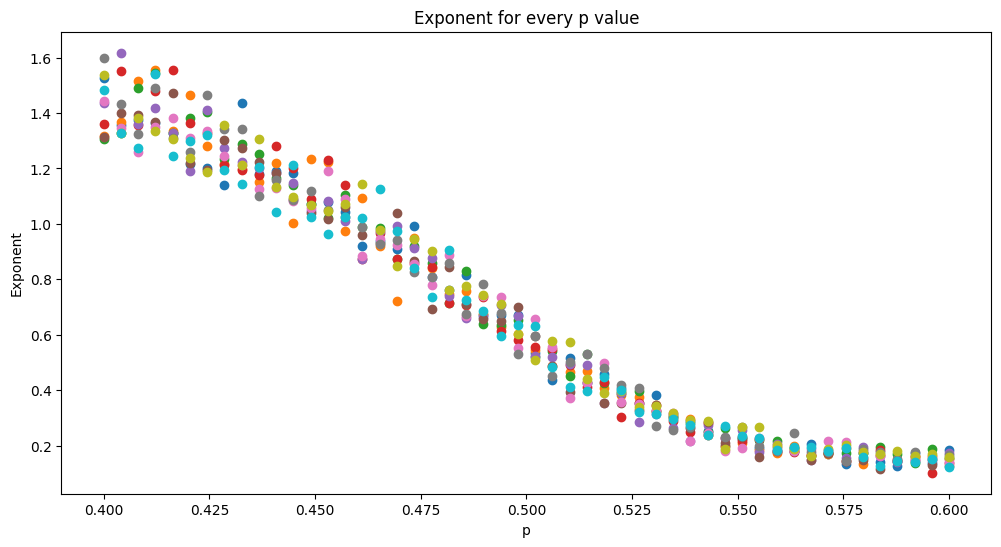

{0.4: [1.52673237179261, 1.3176834549868999, 1.3073523061240357, 1.3591467569728801, 1.4358585785559723, 1.3120017991132964, 1.4444921498736198, 1.5979361652304584, 1.538599891925954, 1.4833394142719512], 0.40408163265306124: [1.3586632015687297, 1.3660284510372087, 1.3280340346575317, 1.552761261778029, 1.6178223082868841, 1.4017456808223827, 1.3471621748612816, 1.4315044953517155, 1.3289881677863442, 1.3278799739971228], 0.40816326530612246: [1.3766715196194639, 1.5168759787428214, 1.4890256506905626, 1.355451554138941, 1.361113150523854, 1.3921989106988388, 1.2608400997593667, 1.3241684292937024, 1.3812563839256762, 1.2743777553891655], 0.4122448979591837: [1.3643993963587786, 1.5542906814951725, 1.5447011500033003, 1.4783335872724424, 1.418396562017829, 1.3668493353764997, 1.3513984833202426, 1.4907309264741297, 1.336965451653531, 1.5393335989895003], 0.4163265306122449: [1.3298242961900466, 1.334305993362924, 1.326390389289671, 1.5561871489397916, 1.3282334404133815, 1.47226586982

In [9]:
importlib.reload(modules)
from modules import run_model_for_densities

p_values = np.linspace(0.4, 0.6, 50) 
p_repetitions = 10
L = 1000
T = int(L / 2)
n = 20

output = run_model_for_densities(p_values, L, T, p_repetitions, n, concurrently=True)
print(output)

# save the output to a csv file
import pandas as pd
df = pd.DataFrame(output)
df.to_csv('output.csv', index=False)

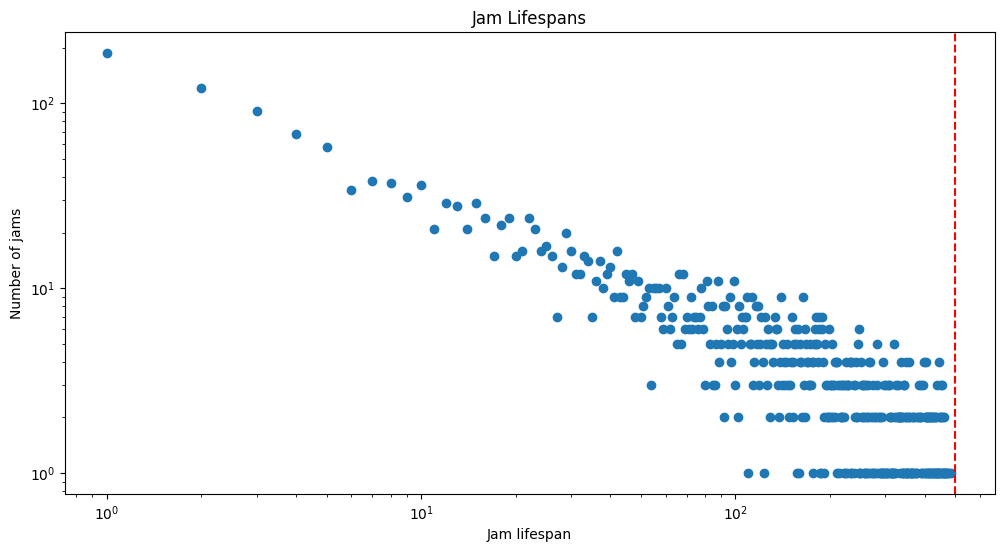

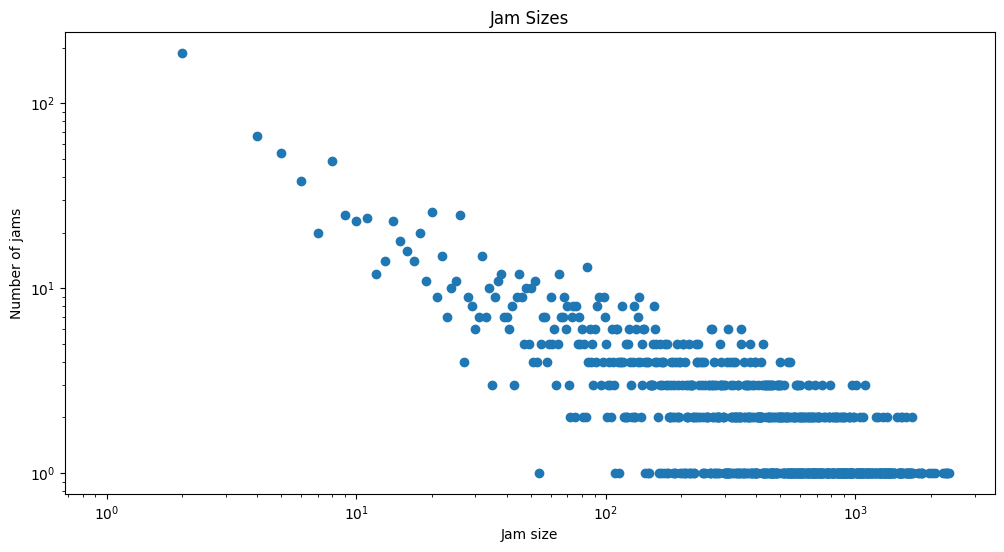

In [67]:
importlib.reload(modules)
from modules import run_model_stochastic

p = 0.5
L = 1000
T = int(L / 2)
n = 20

lifespan_counter, jam_size_counter = run_model_stochastic(p, L, T, n, v_max=1, p_slowdown = 0)

plt.figure(figsize=(12,6))
plt.title(f'Jam Lifespans')
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o')
plt.xlabel('Jam lifespan')
plt.ylabel('Number of jams')

# Add a vertical line at T
plt.axvline(x=T, color='red', linestyle='--')
plt.show()

plt.figure(figsize=(12,6))
plt.title(f'Jam Sizes')
plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o')
plt.xlabel('Jam size')
plt.ylabel('Number of jams')
plt.show()
